In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

In [ ]:
pip install twint

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.5 MB/s eta 0:00:00
  Created wheel for twint: filename=twint-2.1.20-py3-none-any.whl size=33911 sha256=2f46eff2dfffc4d0bdcdc617f0b08c3c33fdaff5f74aa033b08a184db88ef868
  Stored in directory: /root/.cache/pip/wheels/48/d2/f5/7a71ea8b6788b85fac82abf4ef84dac03562571f695c3b8f77
  Created wheel for cchardet: filename=cchardet-2.1.7-cp310-cp310-linux_x86_64.whl size=289270 sha256=252771f1b44572c957ef3d91c1a8acf087d239d1e8290ebac8c70a3e5a0e5167
  Stored in directory: /root/.cache/pip/wheel

In [ ]:
import numpy as np
import pandas as pd
import pickle
import missingno as msno
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig , DistilBertModel
import transformers

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score

import os
import datetime as dt

import twint
from time import sleep
import nest_asyncio
import glob

import warnings
warnings.filterwarnings('ignore')

In [ ]:
PATH = '/content/drive/MyDrive/nlp-data/'

In [ ]:
df_train = pd.read_csv(PATH + "train.csv")
df_test = pd.read_csv(PATH + "test.csv")

print(f"Train: {df_train.shape}, memory usage: {df_train.memory_usage().sum() / 1024**2:0.3f} MB")
print(f"Test: {df_test.shape}, memory usage: {df_test.memory_usage().sum() / 1024**2:0.3f} MB")

Train: (7613, 5), memory usage: 0.291 MB
Test: (3263, 4), memory usage: 0.100 MB


In [ ]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']

print(f"There are {df_mislabeled.shape[0]} mislabeled tweets!!!")

There are 18 mislabeled tweets!!!


In [ ]:
df_mislabeled

text
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                  2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!                             2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                             2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!                                         2
To fight bioterrorism sir.                                                                                                                     2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE    2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption        

In [ ]:
# Visualize mislabeled tweets

df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [ ]:
# Relabeling

df_train['target_relabeled'] = df_train['target'].copy()

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

Text Cleaning

In [ ]:
def text_cleaning(tweet):

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)

    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)

    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet)
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)

    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

    return tweet

In [ ]:
df_train['text_cleaned'] = df_train['text'].apply(lambda s : text_cleaning(s))


In [ ]:
df_exp = df_train.copy()

# word_count
df_exp['word_count'] = df_exp['text_cleaned'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_exp['unique_word_count'] = df_exp['text_cleaned'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_exp['stop_word_count'] = df_exp['text_cleaned'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df_exp['mean_word_length'] = df_exp['text_cleaned'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_exp['char_count'] = df_exp['text_cleaned'].apply(lambda x: len(str(x)))

In [ ]:
df_exp.head()

,id,keyword,location,text,target,target_relabeled,text_cleaned,word_count,unique_word_count,stop_word_count,mean_word_length,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this # earthquake...,14,14,6,4.071429,71
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask . Canada,8,8,0,4.000000,40
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,All residents asked to ' shelter in place ' ...,25,20,11,4.480000,139
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,"13,000 people receive # wildfires evacuation ...",9,9,1,6.333333,67
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby # Alaska a...,18,16,7,4.000000,92


In [ ]:
#Checkpoint
df_train.to_csv("/content/drive/MyDrive/nlp-data/train_clean.csv", index=False)

Data Visualization

In [ ]:
df_train.head()

,id,keyword,location,text,target,target_relabeled,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this # earthquake...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask . Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,All residents asked to ' shelter in place ' ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,"13,000 people receive # wildfires evacuation ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby # Alaska a...


In [ ]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
mask = np.ones(df_train.shape[0], dtype = bool)

Number of words found 3259 

Figure - Word clouds in cleaned text for the disaster tweets



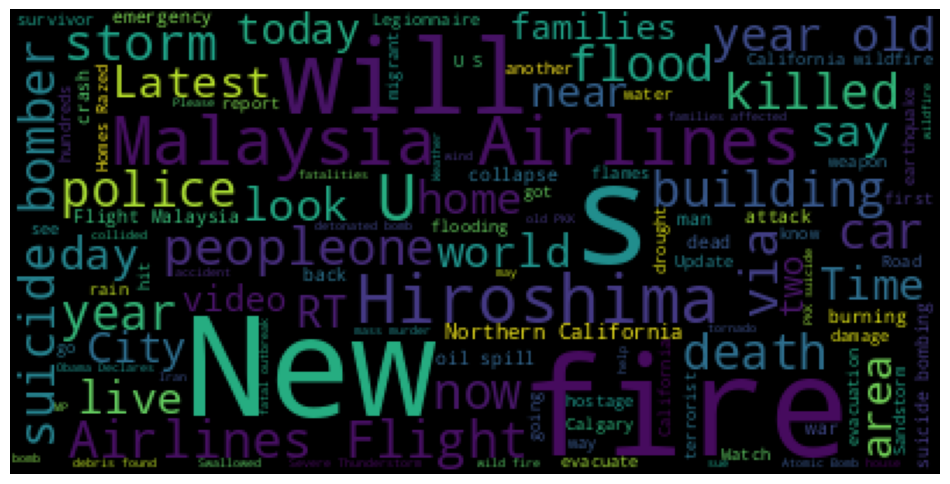

In [ ]:
# creating wordclouds for disaster tweets
mask1 = df_train["target_relabeled"] == 1
words_d = df_train.loc[mask1,"text_cleaned"].values
print("Number of words found", len(words_d),"\n")
print("Figure - Word clouds in cleaned text for the disaster tweets\n")
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                       max_font_size = 60
                         ).generate(" ".join(words_d))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Number of words found 4354 

Figure - Word clouds in cleaned text for NON disaster tweets



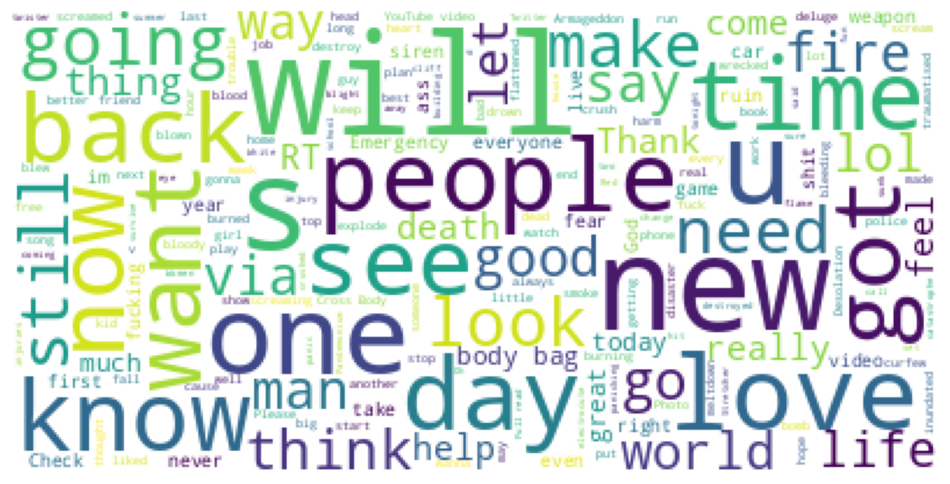

In [ ]:
# creating wordclouds for NON disaster tweets
mask2 = df_train["target_relabeled"] == 0
words_nd = df_train.loc[mask2,"text_cleaned"].values
print("Number of words found", len(words_nd),"\n")
print("Figure - Word clouds in cleaned text for NON disaster tweets\n")
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='white',
                      max_font_size = 60
                         ).generate(" ".join(words_nd))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
def generate_ngrams(text, n_gram=1):
    """
        Generate N-gram on a single piece of text
    """
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

def df_ngrams(df, mask, column, n):
    """
        From a DataFrame, generates 2 DataFrames containing the N-grams according to a mask
    """
    disaster_ngram = defaultdict(int)
    nondisaster_ngram = defaultdict(int)

    for tweet in df[mask][column]:
        for word in generate_ngrams(tweet, n_gram = n):
            disaster_ngram[word] += 1

    for tweet in df[~mask][column]:
        for word in generate_ngrams(tweet, n_gram = n):
            nondisaster_ngram[word] += 1

    df_disaster_ngram = pd.DataFrame(sorted(disaster_ngram.items(), key=lambda x: x[1])[::-1])
    df_nondisaster_ngram = pd.DataFrame(sorted(nondisaster_ngram.items(), key=lambda x: x[1])[::-1])

    return df_disaster_ngram, df_nondisaster_ngram


def plt_ngram(df, mask, column, n):

    # Generate the 2 DataFrames
    df_disaster, df_nondisaster = df_ngrams(df_train, mask, column, n)

    # Visualize
    fig, axes = plt.subplots(ncols=2, figsize=(18, 12 * N/20), dpi=100)
#     plt.tight_layout()

    sns.barplot(y=df_disaster[0].values[:N], x=df_disaster[1].values[:N], ax=axes[0], color = sns.color_palette()[0])
    sns.barplot(y=df_nondisaster[0].values[:N], x=df_nondisaster[1].values[:N], ax=axes[1], color = sns.color_palette()[1])

    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    if n == 1:
        lbl = 'unigrams'
    elif n == 2:
        lbl = 'bigrams'
    elif n == 3:
        lbl = 'trigrams'

    axes[0].set_title(f'Top {N} most common {lbl} in Disaster Tweets', fontsize=15)
    axes[1].set_title(f'Top {N} most common {lbl} in Non-disaster Tweets', fontsize=15)

    plt.show()

In [ ]:
# Set number of most common N-grams to visualize
N = 20

In [ ]:
df_train.head()

,id,keyword,location,text,target,target_relabeled,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this # earthquake...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask . Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,All residents asked to ' shelter in place ' ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,"13,000 people receive # wildfires evacuation ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby # Alaska a...


In [ ]:
import tensorflow as tf

# initiatin the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1500)
tokenizer.fit_on_texts(df_train["text_cleaned"]) #fitting


In [ ]:

# creating encoded text and len of reviews
df_train["text_encoded"] = tokenizer.texts_to_sequences(df_train["text_cleaned"])
df_train["len_review"] = df_train["text_encoded"].apply(lambda x: len(x))

In [ ]:

print("Number of empty cells= ", df_train["text_encoded"].isna().sum())
df_train = df_train[df_train["text_cleaned"]!=0]

Number of empty cells=  0


In [ ]:

df_train.head()

,id,keyword,location,text,target,target_relabeled,text_cleaned,text_encoded,len_review
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this # earthquake...,"[117, 18, 1, 867, 5, 22, 258, 137, 73, 39]",10
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask . Canada,"[190, 42, 233, 767, 1215]",5
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,All residents asked to ' shelter in place ' ...,"[39, 4, 7, 3, 689, 7, 18, 135, 20, 41, 393, 25...",18
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,"13,000 people receive # wildfires evacuation ...","[797, 60, 1496, 259, 1398, 3, 88]",7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby # Alaska a...,"[34, 101, 1216, 22, 329, 24, 31, 277, 24, 1496...",13


In [ ]:
# tenserflow is not capable of creating a tensor with different lenghts
# need to create a single np array before creating tf dataset
# to ensure equal length for each text, apply padding ("pre" or "post")
train_pad = tf.keras.preprocessing.sequence.\
            pad_sequences(df_train.text_encoded, padding="pre")
# keep the length to predictions
maxlen = train_pad.shape[1]
print(maxlen)

30


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/nlp-data/train.csv")

In [ ]:

# checkpoint
#merging preprocessed text with the df
left = dataset
right = df_train
dataset_train= pd.merge(left, right, on='text')
df_train.to_csv("/content/drive/MyDrive/nlp-data/train_clean_tokenized.csv", index=False)

In [ ]:
df_train.head()

,id,keyword,location,text,target,target_relabeled,text_cleaned,text_encoded,len_review
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this # earthquake...,"[117, 18, 1, 867, 5, 22, 258, 137, 73, 39]",10
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask . Canada,"[190, 42, 233, 767, 1215]",5
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,All residents asked to ' shelter in place ' ...,"[39, 4, 7, 3, 689, 7, 18, 135, 20, 41, 393, 25...",18
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,"13,000 people receive # wildfires evacuation ...","[797, 60, 1496, 259, 1398, 3, 88]",7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby # Alaska a...,"[34, 101, 1216, 22, 329, 24, 31, 277, 24, 1496...",13


Spillting data into test and train

In [ ]:
# let's apply tensor_slices of  data set
full_ds = tf.data.Dataset.from_tensor_slices((train_pad, df_train.target.values))

In [ ]:

# splitting into train n test sets by keeping about 85% in the train set.
# I use the `.take` and `.skip` methods on the tensorflow dataset.
# Then, I use `.shuffle` on the train set, and `.batch`on both sets to organise them by batches of 64 observations.
TAKE_SIZE = int(0.85*df_train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [ ]:
 # let's check the batches
text0 = []
for text, target in train_data.take(1):
  text0 = text
  print(text, target)


tf.Tensor(
[[   0    0    0 ...   30   25  312]
 [   0    0    0 ...   50  294  395]
 [   0    0    0 ...  881 1450   94]
 ...
 [   0    0    0 ...   18   16    1]
 [   0    0    0 ...    1  446    1]
 [   0    0    0 ...   50   18 1226]], shape=(64, 30), dtype=int32) tf.Tensor(
[1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0], shape=(64,), dtype=int64)


In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import  SimpleRNN, Dense, GRU, LSTM, Dropout
import json

GAP1D

In [ ]:

vocab_size = len(tokenizer.word_index)
model_gap = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 128, input_shape=[text0.shape[1],],name="embedding"),
                  # Gobal average pooling
                  GlobalAveragePooling1D (),
                  # Dense layers once the data is flat
                  Dense(32, activation='relu'),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  # output layer for the target and sigmoid activation
                  Dense(1, activation="sigmoid")
])

optimizer= tf.keras.optimizers.Adam()
model_gap.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_gap.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           2167808   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [ ]:
# fitting model on 15 epochs with weights
model_gap.fit(train_data,
          epochs=30,
          validation_data=test_data)
#saving model and its history
fname= 'gap1d'
#model_gap.save("models/model_"+fname+".h5")
json.dump(model_gap.history.history, open("/content/drive/MyDrive/nlp-data/"+fname+"_history.json", 'w'))

Epoch 1/30
102/102 [==============================] - 5s 38ms/step - loss: 0.6532 - accuracy: 0.6195 - val_loss: 0.5844 - val_accuracy: 0.7110
Epoch 2/30
102/102 [==============================] - 5s 45ms/step - loss: 0.4622 - accuracy: 0.7971 - val_loss: 0.4770 - val_accuracy: 0.7863
Epoch 3/30
102/102 [==============================] - 5s 51ms/step - loss: 0.3879 - accuracy: 0.8351 - val_loss: 0.4631 - val_accuracy: 0.7863
Epoch 4/30
102/102 [==============================] - 4s 40ms/step - loss: 0.3563 - accuracy: 0.8482 - val_loss: 0.4763 - val_accuracy: 0.7715
Epoch 5/30
102/102 [==============================] - 4s 41ms/step - loss: 0.3433 - accuracy: 0.8620 - val_loss: 0.4855 - val_accuracy: 0.7758
Epoch 6/30
102/102 [==============================] - 4s 37ms/step - loss: 0.3254 - accuracy: 0.8674 - val_loss: 0.5071 - val_accuracy: 0.7601
Epoch 7/30
102/102 [==============================] - 4s 41ms/step - loss: 0.3162 - accuracy: 0.8733 - val_loss: 0.5217 - val_accuracy: 0.7601

In [ ]:
test_loss, test_accuracy = model_gap.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')

18/18 [==============================] - 0s 3ms/step - loss: 1.1957 - accuracy: 0.7102
Test Accuracy: 0.7101576328277588


SimpleRNN

In [ ]:
# following a similar architecture to the previous section
vocab_size = len(tokenizer.word_index)
model_rnn = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 128, input_shape=[text0.shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=16, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(4, activation='relu'),
                  Dense(2, activation='relu'),
                  # output layer for the target and sigmoid activation
                  Dense(1, activation="sigmoid")
])

optimizer= tf.keras.optimizers.Adam()
model_rnn.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           2167808   
                                                                 
 simple_rnn (SimpleRNN)      (None, 30, 64)            12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                1296      
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
Total params: 2181537 (8.32 MB)
Trainable params: 2181

In [ ]:
# fitting model on 15 epochs
model_rnn.fit(train_data,
          epochs=30,
          validation_data=test_data)
#saving model and its history
fname= 'simpleRNN'
#model_rnn.save("models/model_"+fname+".h5")
json.dump(model_rnn.history.history, open("/content/drive/MyDrive/nlp-data/"+fname+"_history.json", 'w'))

Epoch 1/30
102/102 [==============================] - 20s 134ms/step - loss: 0.6545 - accuracy: 0.5866 - val_loss: 0.6388 - val_accuracy: 0.6690
Epoch 2/30
102/102 [==============================] - 7s 73ms/step - loss: 0.5348 - accuracy: 0.7969 - val_loss: 0.6172 - val_accuracy: 0.7093
Epoch 3/30
102/102 [==============================] - 6s 62ms/step - loss: 0.4327 - accuracy: 0.8784 - val_loss: 0.6102 - val_accuracy: 0.7277
Epoch 4/30
102/102 [==============================] - 7s 67ms/step - loss: 0.3585 - accuracy: 0.9065 - val_loss: 0.6499 - val_accuracy: 0.7189
Epoch 5/30
102/102 [==============================] - 6s 60ms/step - loss: 0.2663 - accuracy: 0.9223 - val_loss: 0.7006 - val_accuracy: 0.7180
Epoch 6/30
102/102 [==============================] - 7s 67ms/step - loss: 0.2053 - accuracy: 0.9281 - val_loss: 0.7244 - val_accuracy: 0.7259
Epoch 7/30
102/102 [==============================] - 8s 74ms/step - loss: 0.1561 - accuracy: 0.9468 - val_loss: 0.8290 - val_accuracy: 0.70

In [ ]:
test_loss, test_accuracy = model_rnn.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')

18/18 [==============================] - 0s 11ms/step - loss: 1.6585 - accuracy: 0.6786
Test Accuracy: 0.678633987903595


GRU

In [ ]:
vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 32, input_shape=[text0.shape[1],],name="embedding"),
                  GRU(units=16, return_sequences=True), # maintains the sequential nature
                  GRU(units=8, return_sequences=False), # returns the last output
                  Dense(4, activation='relu'),
                  Dense(2, activation='relu'),
                  # output layer for the target and sigmoid activation
                  Dense(1, activation="sigmoid")
])

optimizer= tf.keras.optimizers.Adam()
model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            541952    
                                                                 
 gru (GRU)                   (None, 30, 16)            2400      
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
 dense_9 (Dense)             (None, 1)                 3         
                                                                 
Total params: 545025 (2.08 MB)
Trainable params: 54502

In [ ]:
# fitting model on 15 epochs
model_gru.fit(train_data,
          epochs=30,
          validation_data=test_data)
#saving model and its history
fname= 'GRU'
#model_gru.save("models/model_"+fname+".h5")
json.dump(model_gru.history.history, open("/content/drive/MyDrive/nlp-data/"+fname+"_history.json", 'w'))

Epoch 1/30
102/102 [==============================] - 15s 50ms/step - loss: 0.6418 - accuracy: 0.5956 - val_loss: 0.6161 - val_accuracy: 0.7005
Epoch 2/30
102/102 [==============================] - 6s 62ms/step - loss: 0.5342 - accuracy: 0.8073 - val_loss: 0.5865 - val_accuracy: 0.7671
Epoch 3/30
102/102 [==============================] - 4s 43ms/step - loss: 0.4860 - accuracy: 0.8308 - val_loss: 0.5868 - val_accuracy: 0.7522
Epoch 4/30
102/102 [==============================] - 5s 52ms/step - loss: 0.4553 - accuracy: 0.8482 - val_loss: 0.5954 - val_accuracy: 0.7373
Epoch 5/30
102/102 [==============================] - 4s 44ms/step - loss: 0.4322 - accuracy: 0.8554 - val_loss: 0.5967 - val_accuracy: 0.7487
Epoch 6/30
102/102 [==============================] - 5s 46ms/step - loss: 0.4076 - accuracy: 0.8665 - val_loss: 0.6124 - val_accuracy: 0.7285
Epoch 7/30
102/102 [==============================] - 6s 62ms/step - loss: 0.3728 - accuracy: 0.8747 - val_loss: 0.6445 - val_accuracy: 0.682

In [ ]:
test_loss, test_accuracy = model_gru.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')

18/18 [==============================] - 0s 8ms/step - loss: 1.1079 - accuracy: 0.6944
Test Accuracy: 0.6943957805633545


LSTM

In [ ]:
vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 128, input_shape=[text0.shape[1],],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  Dense(8, activation='relu'),
                  Dense(2, activation='relu'),
                  Dropout(rate=0.35), # any help of dropout on overfitting ?
                  # output layer for the target and sigmoid activation
                  Dense(1, activation="sigmoid")
])

optimizer= tf.keras.optimizers.Adam()
model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           2167808   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                

In [ ]:
# fitting model on 15 epochs
model_lstm.fit(train_data,
          epochs=30,
          validation_data=test_data)
#saving model and its history
fname= 'LSTM'
#model_lstm.save("models/model_"+fname+".h5")
json.dump(model_lstm.history.history, open("/content/drive/MyDrive/nlp-data/"+fname+"_history.json", 'w'))


Epoch 1/30
102/102 [==============================] - 19s 136ms/step - loss: 0.6907 - accuracy: 0.5746 - val_loss: 0.6913 - val_accuracy: 0.5342
Epoch 2/30
102/102 [==============================] - 12s 118ms/step - loss: 0.6867 - accuracy: 0.5767 - val_loss: 0.6908 - val_accuracy: 0.5342
Epoch 3/30
102/102 [==============================] - 10s 100ms/step - loss: 0.6842 - accuracy: 0.5767 - val_loss: 0.6910 - val_accuracy: 0.5342
Epoch 4/30
102/102 [==============================] - 13s 123ms/step - loss: 0.6829 - accuracy: 0.5767 - val_loss: 0.6916 - val_accuracy: 0.5342
Epoch 5/30
102/102 [==============================] - 12s 120ms/step - loss: 0.6821 - accuracy: 0.5767 - val_loss: 0.6922 - val_accuracy: 0.5342
Epoch 6/30
102/102 [==============================] - 12s 121ms/step - loss: 0.6818 - accuracy: 0.5767 - val_loss: 0.6927 - val_accuracy: 0.5342
Epoch 7/30
102/102 [==============================] - 12s 121ms/step - loss: 0.6816 - accuracy: 0.5767 - val_loss: 0.6930 - val_ac

In [ ]:
test_loss, test_accuracy = model_lstm.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')

18/18 [==============================] - 0s 20ms/step - loss: 0.6944 - accuracy: 0.5342
Test Accuracy: 0.5341506004333496


In [ ]:
df_train['text_cleaned'].shape

(7613,)

Evaluation of Models

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import json


In [ ]:

# for loading history files from local, uncomment below if neccessary

gap1d_history = json.load(open("/content/drive/MyDrive/nlp-data/gap1d_history.json", 'r'))
simpleRNN_history = json.load(open("/content/drive/MyDrive/nlp-data/simpleRNN_history.json", 'r'))
GRU_history = json.load(open("/content/drive/MyDrive/nlp-data/GRU_history.json", 'r'))
LSTM_history = json.load(open("/content/drive/MyDrive/nlp-data/LSTM_history.json", 'r'))

model_hist = [gap1d_history,
              simpleRNN_history,
              GRU_history,
              LSTM_history,
]




model_name =["Baseline GAP1d",
             "Simple RNN",
             "GRU",
             "LSTM"]

In [ ]:
print("Figure - Comparison of deep learning models' performances\n")

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(2,2, figsize = (10,8),
                         sharex=True, sharey=True)

for ii,ax in enumerate(axes.ravel()):
  f0=sns.lineplot(data = pd.DataFrame(model_hist[ii])[["accuracy","val_accuracy"]],
            ax = ax).set(title=model_name[ii])
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/nlp-data/figs/models_accuracy.png")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

vocab_size = len(tokenizer.word_index)

model_lstm_n = Sequential([
    Embedding(vocab_size + 1, 128, input_shape=[text0.shape[1],], name="embedding"),
    Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.3)),
    Bidirectional(LSTM(units=64, return_sequences=False, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dropout(rate=0.5),
    Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm_n.compile(optimizer=optimizer,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])
model_lstm_n.summary()




In [ ]:
# fitting model on 30 epochs
model_lstm_n.fit(train_data,
          epochs=5,
          validation_data=test_data)
#saving model and its history
fname= 'BI-DIRECTIONAL-LSTM'
#model_lstm.save("models/model_"+fname+".h5")
json.dump(model_lstm_n.history.history, open("/content/drive/MyDrive/nlp-data/"+fname+"_history.json", 'w'))



Prediction for submission

In [ ]:

# loading test dataset
dataset_test = pd.read_csv("/content/drive/MyDrive/nlp-data/test.csv")
dataset_test.head()

In [ ]:

# let's take the columns we're interested in
test = dataset_test[["text"]]
test.head()

In [ ]:
# importing Spacy and french initialisation and  Loading `en_core_news_sm`
import en_core_web_sm
nlp = en_core_web_sm.load()


# Importing the stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:

# cleaning test dataset below:
# ---
print("\nStep 1 removing characters from strings that are not alphanumeric (except for whitespaces.)")
test["text_clean"] = test["text"].\
                      apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
print("\nStep 2 replaceing double whitespaces with single whitespaces")
test["text_clean"] = test["text_clean"].\
                      apply(lambda x: x.replace(" +"," ").lower().strip())
print("\nStep 3 converting all characters to lowercase")
test["text_clean"] = test["text_clean"].\
                      apply(lambda x: x.replace("http"," ").lower().strip())
print("\nStep 4 trimming whitespaces at initial and ending locations.")
test["text_clean"] = test["text_clean"].\
                      apply(lambda x: x.replace(" t "," ").lower().strip())
print("\nStep 5 (with spacy) replacing all tokens oin tweets with lemma_ and removing all the stop words.")
test["text_clean"] = test["text_clean"].\
                      apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
print("\n...Done...\n")
test

In [ ]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1500) # instanciate the tokenizer
tokenizer.fit_on_texts(test["text_clean"])
test["text_encoded"] = tokenizer.texts_to_sequences(test["text_clean"])
test["len_review"] = test["text_encoded"].apply(lambda x: len(x))
test = test[test["text_clean"]!=0]
print('max length = ',maxlen)
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test.text_encoded, padding="pre",maxlen=maxlen)

In [ ]:

#loading final model
finalmodel = tf.keras.models.load_model("/content/drive/MyDrive/nlp-data/models/model_final.h5")

In [ ]:
model_predict = finalmodel.predict(test_pad)
test ['prob_']= pd.DataFrame(model_predict)
print("\nFigure - Probability distribution on whether a tweet talks really about disaster or not.\n")
test ['prob_'].plot.hist()

In [ ]:
#merging preprocessed text with the df
left = dataset_test
right = test
dataset_test= pd.merge(left, right, on='text')

In [ ]:
dataset_test['target'] = dataset_test['prob_'].apply(lambda x: int(round(x)))
print("Number of predicted regular [0] and disaster [1] risks: \n")
dataset_test['target'].value_counts()

In [ ]:
dataset_test[['text_clean','target']].sample(10).to_numpy()

In [ ]:
#checkpoint
dataset_test.to_csv('/content/drive/MyDrive/nlp-data/prediction/test_predicted.csv', index=False)


#submission
output = pd.DataFrame({'id': dataset_test["id"],
                       'target': dataset_test["target"]})
output.to_csv('/content/drive/MyDrive/nlp-data/prediction/submission.csv', index=False)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# creating wordclouds for disaster tweets
mask1 = dataset_test["target"] == 1
words_d = dataset_test.loc[mask1,"text_clean"].values
print("Number of words found", len(words_d),"\n")
print("Figure - Word clouds in cleaned text predicted as disaster in submission file\n")
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                       max_font_size = 60
                         ).generate(" ".join(words_d))
plt.imshow(word_cloud)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/nlp-data/figs/wordcloud_testset_disaster.png')
plt.show()